<a href="https://colab.research.google.com/github/MShiloni22/DDBMS_Project_A/blob/master/section03_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 61.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=6e59cff9535b14ccb2e2137b4a147d75b2400f78fa2851d75e864ae91a4406ca
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import findspark
import datetime as dt

findspark.init()
from pyspark.sql import SparkSession
def init_spark(app_name: str):
 spark = SparkSession.builder.appName(app_name).getOrCreate()
 sc = spark.sparkContext
 return spark, sc
spark, sc = init_spark('demo')
sc

<SparkContext master=local[*] appName=demo>

In [4]:
# #%%
# !pip install pyspark
# !pip install findspark
# #%%
# Current file = queries.csv

# Transform the file to tsv format
import csv

with open('/content/drive/MyDrive/Colab Files/DDBMS//queries.csv','r') as csvin, open('queries.tsv', 'w') as tsvout:
    csvin = csv.reader(csvin)
    tsvout = csv.writer(tsvout, delimiter='\t')
    for row in csvin:
        tsvout.writerow(row)

from pyspark.sql import SparkSession,Row, Column
import pyspark.sql.functions as F
spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()
queries_file = 'queries.tsv'
df = spark.read.csv(queries_file, header='True', inferSchema='True', sep='\t')


column_names = ["genres", "lang", "actors", "director", "cities", "country", 
                "from_realese_date", "production_company"]
# For all the above columns
for name in column_names:
  temp_name_1 = name + "1"
  temp_name_2 = name + "2"
  # Removing irrelevant chars
  df = df.select("*", F.translate(F.col(name), "'[]", "")\
                .alias(temp_name_1))\
  .drop(name)

  # Converting arrays strings to arrays of strings
  df = df.select("*", F.split(F.col(temp_name_1),",").alias(temp_name_2)) \
      .drop(temp_name_1)
  df = df.withColumnRenamed(temp_name_2,name)

print("Queries table:")
df.show()
queries_df = df

# ------------------------------------------------------------------------------

# Current file: credits.csv
import re
credits_file = '/content/drive/MyDrive/Colab Files/DDBMS//credits.csv'
df = spark.read.csv(credits_file, header='True', inferSchema='True')

# load the data as you did before,
# just now change the delimiter to get evreything together
credits = spark.read.format("csv")\
.option("delimiter", "\t")\
.option("header","true")\
.option("inferSchema", "true")\
.load("drive/MyDrive/Colab Files/DDBMS//credits.csv")
prog = re.compile('\\[(.*?)\\]')
second_match = F.udf(lambda x: prog.findall(x)[1])
id_extract = F.udf(lambda x: x.split(",")[-1])
credits = credits\
.withColumn("id", id_extract("cast,crew,id"))\
.withColumn("cast", F.regexp_extract(F.col("cast,crew,id"), '\\[(.*?)\\]', 0
))\
.withColumn("crew", F.concat(F.lit("["),second_match("cast,crew,id"), F.lit(
"]")))\
.select("cast", "crew", "id")
df = credits
# df.printSchema()
column_names = ["cast", "crew"]
# For all the above columns
for name in column_names:
  temp_name_1 = name + "1"
  temp_name_2 = name + "2"
  # Removing irrelevant chars
  df = df.select("*", F.translate(F.col(name), "\\{\\[\\]'\\}", "")\
                .alias(temp_name_1))\
  .drop(name)

  # Converting arrays strings to arrays of strings
  df = df.select("*", F.split(F.col(temp_name_1),",").alias(temp_name_2)) \
      .drop(temp_name_1)
  df = df.withColumnRenamed(temp_name_2,name)

# For cast column - udf for extracting actors' names only from cast json string
actors_udf = F.udf(lambda arr: [arr[i][7:] for i in range(len(arr)) if i % 8 == 5])
df = df.withColumn('actors', actors_udf(F.col("cast")))\
  .drop("cast")

# For crew column - udf for extracting directors' names only from crew json string
directors_udf = F.udf(lambda arr: [arr[i+1][7:] for i in range(len(arr))
 if arr[i] == " job: Director"])
df = df.withColumn('directors', directors_udf(F.col("crew")))\
  .drop("crew")

# Converting arrays strings to arrays of strings
column_names = ["actors", "directors"]
for name in column_names:
  temp_name_1 = name + "1"
  temp_name_2 = name + "2"
  # Removing irrelevant chars
  df = df.select("*", F.translate(F.col(name), "\\{\\[\\]'\\}", "")\
                .alias(temp_name_1))\
  .drop(name)

  # Converting arrays strings to arrays of strings
  df = df.select("*", F.split(F.col(temp_name_1),",").alias(temp_name_2)) \
      .drop(temp_name_1)
  df = df.withColumnRenamed(temp_name_2,name)

print("Credits table:")
df.show()
credits_df = df

# ------------------------------------------------------------------------------

# Current file: movies.csv
movies_file = '/content/drive/MyDrive/Colab Files/DDBMS//movies.csv'
df = spark.read.csv(movies_file, header='True', inferSchema='True')

# Doing the same process for all columns
column_names = ["genres", "production_companies", "production_countries", 
                "spoken_languages", "cities"]
for name in column_names:
  temp_name_1 = name + "1"
  temp_name_2 = name + "2"
  # Removing irrelevant chars
  df = df.select("*", F.translate(F.col(name), "\\{\\[\\]'\\}", "")\
                .alias(temp_name_1))\
  .drop(name)

  # Converting arrays strings to arrays of strings
  df = df.select("*", F.split(F.col(temp_name_1),",").alias(temp_name_2)) \
      .drop(temp_name_1)
  df = df.withColumnRenamed(temp_name_2,name)

# Finished working on cities column, and seperating production_companies
# because it has different structure
column_names = ["genres", "production_countries", "spoken_languages"]

# For each column - udf for extracting names only from json string
name_udf = F.udf(lambda arr: [arr[i][7:] for i in range(len(arr)) if i % 2 == 1])
for c in column_names:
  c_1 = c + "1"
  df = df.withColumn(c_1, name_udf(F.col(c)))\
    .drop(c)
prod_udf = F.udf(lambda arr: [arr[i][6:] for i in range(len(arr)) if i % 2 == 0])
df = df.withColumn("production_companies1", prod_udf(F.col("production_companies")))\
  .drop("production_companies")

# Renameing columns names
column_names = ["genres", "production_companies", "production_countries", 
                "spoken_languages"]
for name in column_names:
  current_name = name + "1"
  df = df.withColumnRenamed(current_name,name)

print("Movies table:")
df.show()
movies_df = df

Queries table:
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|user_id|              genres|                lang|              actors|            director|              cities|             country|from_realese_date|  production_company|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+
|    981| [Western,  Mystery]|  [English,  Srpski]|                  []|      [Nae Caranfil]|  [Haifa,  Tiberias]|                  []|           [2012]|[Katakuri-ke no K...|
|   3775|  [Action,  Western]|           [English]|                  []|                  []|          [Tel Aviv]|                  []|           [2013]|[Clavius Base,  T...|
|   4095|             [Crime]|[English,  עִבְרִית]|[Kenneth Alton,  ...|                  []|         [Jerusal

Insight 1: Tel Aviv is the most queried city with 44721 lookups, Jerusalem is right after with 34561, and then Haifa, Tiberias and Eilat with 22712, 9594 and 17348 lookups respectively
{'Tel Aviv': 44721, 'Jerusalem': 34561, 'Haifa': 22712, 'Tiberias': 9594, 'Eilat': 17348}

Insight 2: Jerusalemites and Tel-Avivians are almost the only ones to search for movies in Hebrew:
{'Tel Aviv': 15958, 'Jerusalem': 26274, 'Haifa': 104, 'Tiberias': 56, 'Eilat': 67}

Insight 3: Jerusalemites care about the playing actors, Haifa people care about directors, and Eilaties alaways specify countries in their queries.

actors empty by city:
{'Tel Aviv': 13884, 'Jerusalem': 3322, 'Haifa': 11394, 'Tiberias': 4815, 'Eilat': 17348}

director empty by city:
{'Tel Aviv': 42147, 'Jerusalem': 33482, 'Haifa': 2784, 'Tiberias': 5477, 'Eilat': 16816}

country empty by city:
{'Tel Aviv': 25335, 'Jerusalem': 3584, 'Haifa': 20992, 'Tiberias': 4149, 'Eilat': 0}

Insight 4: people who look for movies in Eilat, never loo

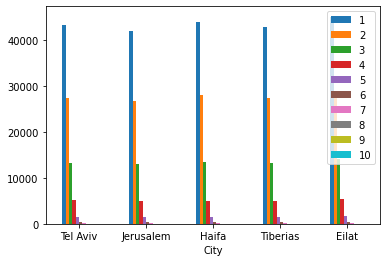

In [53]:
#%%
# Section 2 - Data Analysis

# Insight 1: Tel Aviv is the most queried city with 44721 lookups, Jerusalem is right after with 34561
# and then Haifa, Tiberias and Eilat with 22712, 9594 and 17348 lookups respectively
queries_itr = queries_df.rdd.toLocalIterator()
counters = {"Tel Aviv": 0, "Jerusalem": 0, "Haifa": 0, "Tiberias": 0, "Eilat": 0,
          " Tel Aviv": 0, " Jerusalem": 0, " Haifa": 0, " Tiberias": 0, " Eilat": 0}
for row in queries_itr:
  for city in row.cities:
    counters[city] += 1

counters_final = {"Tel Aviv": counters["Tel Aviv"] + counters[" Tel Aviv"],
                "Jerusalem": counters["Jerusalem"] + counters[" Jerusalem"],
                "Haifa": counters["Haifa"] + counters[" Haifa"],
                "Tiberias": counters["Tiberias"] + counters[" Tiberias"],
                "Eilat": counters["Eilat"] + counters[" Eilat"]}

print("Insight 1: Tel Aviv is the most queried city with 44721 lookups, Jerusalem is right after with 34561, and then Haifa, Tiberias and Eilat with 22712, 9594 and 17348 lookups respectively")
print(counters_final)
print()

# Insight 2: Jerusalemites and Tel-Avivians are almost the only ones to search for movies in Hebrew
queries_itr = queries_df.rdd.toLocalIterator()
counters = {"Tel Aviv": 0, "Jerusalem": 0, "Haifa": 0, "Tiberias": 0, "Eilat": 0,
            " Tel Aviv": 0, " Jerusalem": 0, " Haifa": 0, " Tiberias": 0, " Eilat": 0}

for row in queries_itr:
  if " עִבְרִית" in row.lang:
    for city in row.cities:
      counters[city] += 1

counters_final = {"Tel Aviv": counters["Tel Aviv"] + counters[" Tel Aviv"],
                  "Jerusalem": counters["Jerusalem"] + counters[" Jerusalem"],
                  "Haifa": counters["Haifa"] + counters[" Haifa"],
                  "Tiberias": counters["Tiberias"] + counters[" Tiberias"],
                  "Eilat": counters["Eilat"] + counters[" Eilat"]}

print("Insight 2: Jerusalemites and Tel-Avivians are almost the only ones to search for movies in Hebrew:")
print(counters_final)
print()


# Insight 3: Jerusalemites care about the playing actors, Haifa people care 
# about directors, and Eilaties alaways specify countries in their queries.
print("Insight 3: Jerusalemites care about the playing actors, Haifa people care about directors, and Eilaties alaways specify countries in their queries.")
queries_itr = queries_df.rdd.toLocalIterator()
counters = {"Tel Aviv": 0, "Jerusalem": 0, "Haifa": 0, "Tiberias": 0, "Eilat": 0,
          " Tel Aviv": 0, " Jerusalem": 0, " Haifa": 0, " Tiberias": 0, " Eilat": 0}
for row in queries_itr:
  if row.actors[0] == "":
    for city in row.cities:
      counters[city] += 1

counters_final = {"Tel Aviv": counters["Tel Aviv"] + counters[" Tel Aviv"],
                "Jerusalem": counters["Jerusalem"] + counters[" Jerusalem"],
                "Haifa": counters["Haifa"] + counters[" Haifa"],
                "Tiberias": counters["Tiberias"] + counters[" Tiberias"],
                "Eilat": counters["Eilat"] + counters[" Eilat"]}

print()
print("actors empty by city:")
print(counters_final)
print()

queries_itr = queries_df.rdd.toLocalIterator()
counters = {"Tel Aviv": 0, "Jerusalem": 0, "Haifa": 0, "Tiberias": 0, "Eilat": 0,
          " Tel Aviv": 0, " Jerusalem": 0, " Haifa": 0, " Tiberias": 0, " Eilat": 0}
for row in queries_itr:
  if row.director[0] == "":
    for city in row.cities:
      counters[city] += 1

counters_final = {"Tel Aviv": counters["Tel Aviv"] + counters[" Tel Aviv"],
                "Jerusalem": counters["Jerusalem"] + counters[" Jerusalem"],
                "Haifa": counters["Haifa"] + counters[" Haifa"],
                "Tiberias": counters["Tiberias"] + counters[" Tiberias"],
                "Eilat": counters["Eilat"] + counters[" Eilat"]}

print("director empty by city:")
print(counters_final)
print()

queries_itr = queries_df.rdd.toLocalIterator()
counters = {"Tel Aviv": 0, "Jerusalem": 0, "Haifa": 0, "Tiberias": 0, "Eilat": 0,
          " Tel Aviv": 0, " Jerusalem": 0, " Haifa": 0, " Tiberias": 0, " Eilat": 0}
for row in queries_itr:
  if row.country[0] == "":
    for city in row.cities:
      counters[city] += 1

counters_final = {"Tel Aviv": counters["Tel Aviv"] + counters[" Tel Aviv"],
                "Jerusalem": counters["Jerusalem"] + counters[" Jerusalem"],
                "Haifa": counters["Haifa"] + counters[" Haifa"],
                "Tiberias": counters["Tiberias"] + counters[" Tiberias"],
                "Eilat": counters["Eilat"] + counters[" Eilat"]}

print("country empty by city:")
print(counters_final)
print()

# Insight 4: people who look for movies in Eilat, never look for movies in over places in the same query
queries_itr = queries_df.rdd.toLocalIterator()
city_lookup_dict = {}
for row in queries_itr:
  key = " ".join(str(x) for x in row.cities)
  if key not in city_lookup_dict.keys():
    city_lookup_dict[key] = 1
  else:
    city_lookup_dict[key] += 1
print("Insight 4: people who look for movies in Eilat, never look for movies in over places in the same query")
print("Lookups for cinemas in different cities counts")
print(city_lookup_dict)
print()

# Insight 5: the number of tickets in reservations are more or less in the same amount and from the same distribution
print("Insight 5: the number of tickets in reservations are more or less in the same amount and from the same distribution")
import pandas as pd
tickets_by_city = [["Tel Aviv", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ["Jerusalem", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   ["Haifa", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ["Tiberias", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   ["Eilat", 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
tickets_by_city = pd.DataFrame(tickets_by_city, columns=["City", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
tickets_by_city.set_index("City", inplace=True)

tickets_df = spark.read.csv('/content/drive/MyDrive/Colab Files/DDBMS//tickets.csv', header='True', inferSchema='True')
tickets_itr = tickets_df.rdd.toLocalIterator()
for row in tickets_itr:
  tickets_by_city.at[row.city, str(row.number_of_tickets)] += 1

print("Number of tickets per reservation count by city")
print(tickets_by_city)
print()
ax = tickets_by_city.plot.bar(rot=0)
ax.plot()
#%% md

# Insight 6: Approximately 95% of the users looked for movies in their home towns
print("Insight 6: Approximately 95% of the users looked for movies in their home towns")
users_df = spark.read.csv('/content/drive/MyDrive/Colab Files/DDBMS//users.csv', header='True', inferSchema='True')
unit = users_df.join(queries_df, on=users_df.user_id == queries_df.user_id)
unit_itr = unit.rdd.toLocalIterator()
cnt = 0
for row in unit_itr:
  loc = row.user_location
  loc_ = " " + row.user_location
  if loc in row.cities or loc_ in row.cities:
    cnt += 1

print(cnt)

# Insight 7: Most genres are queried in the same propotion, beside a few of them,
# which are significantly more popular
print("Insight 7: Most genres are queried in the same propotion, beside a few of them,\
 which are significantly more popular")
all_genres = set()
queries_itr = queries_df.rdd.toLocalIterator()
for row in queries_itr:
  for g in row.genres:
    if g != "" and not( " " + g in all_genres):
      all_genres.add(g)

all_genres_2 = set(all_genres)
for strr in all_genres:
  if strr[0] == " ":
    all_genres_2.add(strr[1:])
    all_genres_2.remove(strr)

queries_itr = queries_df.rdd.toLocalIterator()
counters = {}
for g in all_genres_2:
  counters[g] = 0

for row in queries_itr:
  for g in row.genres:
    if g != "":
      counters[g.lstrip()] += 1

print(counters)


In [52]:
# Insight 7: Most genres are queried in the same propotion, beside a few of them,
# which are significantly more popular
print("Insight 7: Most genres are queried in the same propotion, beside a few of them,\
 which are significantly more popular")
all_genres = set()
queries_itr = queries_df.rdd.toLocalIterator()
for row in queries_itr:
  for g in row.genres:
    if g != "" and not( " " + g in all_genres):
      all_genres.add(g)

all_genres_2 = set(all_genres)
for strr in all_genres:
  if strr[0] == " ":
    all_genres_2.add(strr[1:])
    all_genres_2.remove(strr)

queries_itr = queries_df.rdd.toLocalIterator()
counters = {}
for g in all_genres_2:
  counters[g] = 0

for row in queries_itr:
  for g in row.genres:
    if g != "":
      counters[g.lstrip()] += 1

print(counters)

Insight 7: Most genres are queried in the same propotion, beside a few of them, which are significantly more popular
{'Music': 7741, 'Action': 26630, 'TV Movie': 7641, 'Science Fiction': 7763, 'Fantasy': 7689, 'Drama': 24542, 'Adventure': 7692, 'Crime': 7755, 'Foreign': 7751, 'Family': 10227, 'Romance': 7654, 'Thriller': 7618, 'Comedy': 7684, 'Documentary': 10116, 'Western': 7608, 'Mystery': 7809, 'Animation': 7720, 'Horror': 7576, 'War': 7822, 'History': 7661}


In this part of the project we have chosen to focus on finding insights mainly from the "queries" table as well as from the "tickets" table, and in particular those that will help us in the horizontal fregmentation, since the vertical fregmenataion is more easy to implement by code and the horizontal is more dependent on our previous knowladge about the database.

Since the general task in this part of the project is to divide the database between sites that are geographically close to the cities of Haifa, Tiberias, Tel Aviv, Jerusalem and Eilat, we found it appropriate to focus on the differences embodied in the database between the cities, hoping that if we find significant differences between cities, we would be able to generalize them for certain rows / columns in the database.

Indeed, we have found some interesting insights, as one can see from the above code output:

1. Jerusalemites and Tel-Avivians are almost the only ones to search for movies in Hebrew.
2. Jerusalemites care much about the playing actors, Haifa people care much about directors, and Eilaties alaways specify countries in their queries.
3. People who look for movies in Eilat, never look for movies in over places in the same query.
4. The numbers of tickets in reservations are more or less in the same amount and from the same distribution.

In [6]:
# Section 3 - Design
# here we will work on vertical fragmantations only.
# for horizontal fragmantation look section's pdf.

import sys
import numpy as np
from collections import Counter

# statistics about the nature of qureries
# from here and on, we will consider these as generic queries with the calculated query-access
def row_counter(my_array):
    # count identical rows in matrix
    list_of_tups = [tuple(ele) for ele in my_array]
    return Counter(list_of_tups)

# build use matrix for queries and shrink it
shape = (queries_df.count(), len(queries_df.columns))
queries_use = np.zeros(shape)
queries_itr = queries_df.rdd.toLocalIterator()
for i, row in enumerate(queries_itr):
  for j, col in enumerate(queries_df.columns):
    if type(row[col]) != list:
      queries_use[i, j] = 1
    else:
      queries_use[i, j] = 0 if row[col][0] == "" else 1

access = row_counter(queries_use)

for key, value in access.items():
    print(f"{key} : {value}")

# user_id | genres | lang | actors | director | cities | country | from_realese_date | production_company

(1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0) : 10046
(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0) : 12416
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 31305
(1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 965
(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 21205
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0) : 12620
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0) : 9983
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 1308
(1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 64
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0) : 3
(1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 3
(1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0) : 70
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0) : 5
(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) : 4
(1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0) : 1
(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0) : 2


In [32]:
n_queries = 8
n_attributes = 2
#attribute usage matrix on movies

# actors | director
aum = [ [0.0, 1.0],
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [1.0, 0.0],
        [1.0, 1.0],
        [1.0, 1.0]]

#number of sites
n_sites = 5

#access matrix
acc = [[10046/200000, 10046/200000,10046/200000,10046/200000,10046/200000, 10046/200000],
       [12412/600000, 12416/200000,12416/200000,12416/200000,12416/200000, 12416/200000],
       [31305/200000, 31305/200000,31305/200000,31305/200000,31305/200000, 31305/200000],
       [965/200000, 965/200000,965/200000,965/200000,965/200000, 965/200000],
       [21205/200000, 21205/200000,21205/200000,21205/200000,21205/200000, 21205/200000],
       [12620/200000, 12620/200000,12620/200000,12620/200000,12620/200000, 12620/200000],
       [9983/200000, 9983/200000,9983/200000,9983/200000,9983/200000, 9983/200000],
       [1308/200000, 1308/200000,1308/200000,1308/200000,1308/200000, 1308/200000],
       ]

In [33]:
#prefix sum for each query
pre = [0 for i in range(n_queries)]
for i in range(n_queries):
    for j in range(n_sites):
        pre[i] = pre[i]+acc[i][j]

#attribute affinity matrix
aam = [[0 for i in range(n_attributes)] for j in range(n_attributes)]

#calculation of the aam
for i in range(n_attributes):
    for j in range(n_attributes):
         for q in range(n_queries):
            if aum[q][i]==1 and aum[q][j]==1:
                aam[i][j] = aam[i][j]+pre[q]
          
print("Attribute affinity matrix")
for i in range(n_attributes):
    print(aam[i])
print("Access Site Sums")
print(pre)

Attribute affinity matrix
[1.3804, 0.282275]
[0.282275, 0.55755]
Access Site Sums
[0.25115, 0.26900666666666667, 0.782625, 0.024125, 0.530125, 0.3155, 0.249575, 0.0327]


In [34]:
def bond(Ax,Ay):
    if Ax==-1 or Ay==-1:
        return 0
    ans = 0
    for i in range(n_attributes):
        ans = ans + (aam[i][Ax]*aam[i][Ay])
    return ans

def cont(Ai,Ak,Aj):
    print("bond ",Ai, "bond", Ak, " = ", bond(Ai,Ak))
    print("bond ",Ak, "bond", Aj, " = ", bond(Ak,Aj))
    print("bond ",Ai, "bond", Aj, " = ", bond(Ai,Aj))
    return 2*bond(Ai,Ak) + 2*bond(Ak,Aj) - 2*bond(Ai,Aj)

In [35]:
#Bond energy algorithm
def BEA():
    ca = []
    ca.append(0)
    ca.append(1)
    index  = 2
    while index < n_attributes:
        maxi = -1 
        maxc = -100000
        for i in range(1,index):
                con = cont(ca[i-1],index,ca[i])
                print("Index ", i+1, " ", "cont ", ca[i],index+1,ca[i]+1, con)
                if con > maxc:
                    maxi = i
                    maxc = con
        #boundary left
        con = cont(-1,index,ca[0])
        print("Index ", i+1, " ", "cont ", 1,index+1,ca[0]+1, con)
        if con > maxc:
            maxi = 0
            maxc = con
        #boundary right
        con = cont(ca[index-1],index,-1)
        print("Index ", i+1, " ", "cont ", ca[index-1]+1,index+1,index+2, con)
        if con > maxc:
            maxi = index
        if maxi==index:
            ca.append(index)    
        else:
            ca.append(0)
            for j in range(index,maxi,-1):
                ca[j]=ca[j-1]
            ca[maxi] = index
        print(ca)
        index = index + 1
    print("FINAL Clustered Affinity Matrix")
    print(ca)
    return ca

In [36]:
CA = BEA()
ca = [[0 for i in range(n_attributes)] for j in range(n_attributes)]
for i in range(n_attributes):
    for j in range(n_attributes):
        ca[i][j] = aam[CA[i]][CA[j]]

print(ca)

FINAL Clustered Affinity Matrix
[0, 1]
[[1.3804, 0.282275], [0.282275, 0.55755]]


In [37]:
def shift_row_aum(mat):
    row_first=[]
    for i in range(n_attributes):
        row_first.append(mat[0][i])
    for i in range(1,n_queries):
        for j in range(n_attributes):
            mat[i-1][j]=mat[i][j]
    for i in range(n_attributes):
        mat[n_queries-1][i]=row_first[i]
   # print(row_first)
    return mat
   
def shift_column_aum(mat):
    col_first=[]
    for i in range(n_queries):
        col_first.append(mat[i][0])
    for i in range(n_queries):
        for j in range(1,n_attributes):
            mat[i][j-1]=mat[i][j]
    for i in range(n_queries):
        mat[i][n_attributes-1]=col_first[i]
    return mat

In [38]:
def shift_row_ca(mat):
    row_first=[]
    for i in range(n_attributes):
        row_first.append(mat[0][i])
    for i in range(1,n_attributes):
        for j in range(n_attributes):
            mat[i-1][j]=mat[i][j]
    for i in range(n_attributes):
        mat[n_attributes-1][i]=row_first[i]
   # print(row_first)
    return mat
   
def shift_column_ca(mat):
    col_first=[]
    for i in range(n_attributes):
        col_first.append(mat[i][0])
    for i in range(n_attributes):
        for j in range(1,n_attributes):
            mat[i][j-1]=mat[i][j]
    for i in range(n_attributes):
        mat[i][n_attributes-1]=col_first[i]
    return mat

In [39]:
#Partioning
# this block computes access-query
# output - list of list, in each list i we see the attributes accessed by query i
start=n_attributes-2
aum = [ [0.0, 1.0],
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [1.0, 0.0],
        [1.0, 1.0],
        [1.0, 1.0]]
AQ=[]
for i in range(n_queries):
    row=[]
    for j in range(n_attributes):
        if aum[i][j]==1:
            row.append(j)
    AQ.append(row)

print(AQ)

[[1], [], [0], [1], [], [0], [0, 1], [0, 1]]


In [40]:
# computing TQ, BQ, OQ and costs for each permutation

# all permutations of attributes
shifts_list = [CA]
shifted = list(CA)
for i in range(len(CA)-1):
  shifted.append(shifted[0])
  shifted.pop(0)
  shifts_list.append(list(shifted))

# compute best vertical fragmantation
max_res = -np.inf
for shift in shifts_list:
  for seperator in range(1, len(shift)):
    TQ=[]
    BQ=[]
    OQ=[]
    until_seperator = shift[:seperator]
    from_seperator = shift[seperator:]
    # paritioned queries to TQ/BQ/OQ 
    for i in range(len(AQ)):
      if set(AQ[i]).issubset(set(until_seperator)):
        TQ.append(i)
      elif set(AQ[i]).issubset(set(from_seperator)):
        BQ.append(i)
      elif set(AQ[i]).issubset(set(shift)):
        OQ.append(i)
    CTQ = np.array([acc[i] for i in TQ]).sum(axis=0).sum()
    CBQ = np.array([acc[i] for i in BQ]).sum(axis=0).sum()
    COQ = np.array([acc[i] for i in OQ]).sum(axis=0).sum()
    res = CTQ*CBQ - COQ**2
    if res > max_res:
      max_res = res
      res_shift = shift
      res_seperator = [until_seperator, from_seperator]

print(f"vertical fragmantation: {res_seperator}")
print(f"max res = {max_res}")

vertical fragmantation: [[1], [0]]
max res = 1.5951304620999998
